In [1]:
%load_ext autoreload
%autoreload 2

In [1]:
import sys
sys.path.append('../../')

from phys_ml import metrics
from phys_ml.evaluation import vertex as verteval
from phys_ml.load_data.vertex import *
from phys_ml.trainer import TrainerModes
from phys_ml.trainer.vertex import *
from phys_ml.util import slurm_generate
from phys_ml.visualization import vertex_visualization as vertvis

In [47]:
# latent space
trainer = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX', 
                        config_kwargs={'path_train': '../../../frgs'})
ls = trainer.load_latentspace('saves/vertex/save_AUTO_ENCODER_VERTEX_BS20_2024-12-06/version_0')
ls.shape

(576, 576, 128)

In [ ]:
n = 38800
f'{n // 3600}h {n % 3600 // 60}m {n % 60}s'

In [ ]:
%load_ext tensorboard
%tensorboard --logdir saves

### slurm

In [ ]:
sample_count = int((2000 * 576 * 3) / (24 * 6))
hidden_dims = [128, 64, 32]
trainer_kwargs = {
    'config_name': 'confmod_auto_encoder.json', 
    'subconfig_name': 'AUTO_ENCODER_VERTEX_24X6', 
    'config_kwargs': {
        'path_train': '/gpfs/data/fs71925/shepp123/frgs_6d',
        'hidden_dims': hidden_dims,
        'epochs': 100,
        'sample_count_per_vertex': sample_count, 
        'test_ratio': 0.2, 
        'subset': -1, 
        'subset_shuffle': False, 
        'devices': 'auto', 
        'device_type': 'gpu', 
        'num_dataloader_workers': 8, 
        'batch_size': 2048,
    }
}
slurm_options = slurm_generate.SlurmOptions(qos='zen3_0512_a100x2_devel', time='00:10:00')
slurm_generate.create(project_name='vertex_24x6', script_name='vsc_test', 
                      pyenv_dir='/gpfs/data/fs71925/shepp123/PhysML/.venv', slurm_options=slurm_options, 
                      trainer='vertex.VertexTrainer24x6', trainer_kwargs=trainer_kwargs)

In [ ]:
# create slurm- and train-script from config-file
!python phys_ml/util/slurm_generate.py configs/confmod_auto_encoder_v2.json

# dev

In [64]:
trainer = VertexTrainer(project_name='vertex', config_name='confmod_auto_encoder.json', 
                        subconfig_name='AUTO_ENCODER_VERTEX', 
                        config_kwargs={'path_train': '../../../frgs', 'subset': 10, 'subset_shuffle': False})

## Transforming 576^3-matrix to 24^6-matrix

In [1]:
### prepare test matrices
import random
import time
import numpy as np


def print_mat_stats(m):
    print(f'dim: {len(m.shape)}, shape: {m.shape}, size: {m.size}, sum: {m.sum()}')
    #print(m)

random.seed(42)
np.random.seed(42)

n_freq = 24
space_dim = 2
k_dim = 3
dim = space_dim * k_dim
length = n_freq**space_dim

#m576_3 = np.ones((length,) * k_dim)
m576_3 = np.random.rand(*((length,) * k_dim))
m24_6 = np.zeros((n_freq,) * dim)
control_idcs = np.random.randint(0, n_freq, (8, dim))
control_items = [m576_3[idx[0] * n_freq + idx[1], 
                        idx[2] * n_freq + idx[3], 
                        idx[4] * n_freq + idx[5]] for idx in control_idcs]
print_mat_stats(m576_3)
print_mat_stats(m24_6)
print('random control indices:\n', control_idcs)
print('random control items:', control_items)

dim: 3, shape: (576, 576, 576), size: 191102976, sum: 95551209.18438378
dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 0.0
random control indices:
 [[12 11 14  8  5 17]
 [ 6 22  1 20 10  3]
 [15  7 22 10 11  5]
 [12  9  6 11 20 10]
 [ 1 19 18 12  2 13]
 [22 16 11 10  9  9]
 [ 6  0 21 12 11 19]
 [15 12 13 12 15 22]]
random control items: [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [2]:
### method 1
t0 = time.time()


def transform_index(i: int) -> tuple[int, int]:
    return (i // n_freq, i % n_freq)


def transform_indices(*indices: int) -> list[int]:
    return [j for i in indices for j in transform_index(i)]


# unpack to 24^6 matrix
m24_6 = np.empty((n_freq,) * dim)
k = np.arange(length)
for i_k1 in range(length):
    for i_k2 in range(length):
        m24_6[*transform_indices(i_k1, i_k2), k // n_freq, k % n_freq] = m576_3[i_k1, i_k2, :]

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 6.784s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [3]:
### method 2
t0 = time.time()

m24_6 = np.zeros((n_freq,) * dim)
for i in range(n_freq):
    for j in range(n_freq):
        for k in range(n_freq):
            m24_6[i, :, j, :, k, :] = m576_3[i * n_freq : (i + 1) * n_freq, 
                                             j * n_freq : (j + 1) * n_freq, 
                                             k * n_freq : (k + 1) * n_freq]

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.907s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [4]:
### method 3
t0 = time.time()

m24_6 = np.zeros((n_freq,) * dim)
for i in range(n_freq):
    for j in range(n_freq):
        m24_6[i, :, j, :, :, :] = m576_3[i * n_freq : (i + 1) * n_freq, 
                                         j * n_freq : (j + 1) * n_freq, 
                                         :].reshape((n_freq,) * 4)

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.541s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [5]:
### method 4
t0 = time.time()

m24_6 = m576_3.reshape((n_freq,) * dim)

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', check_items == control_items, check_items)


time: 0.117s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: True [0.2231108298526705, 0.3851128173293077, 0.7680790819330442, 0.10912941790135045, 0.34650971575367395, 0.8493269356006744, 0.45857532270248447, 0.4882521434863434]


In [6]:
### counter check
t0 = time.time()

m24_6 = m576_3.reshape((n_freq,) * dim, order='F')

check_items = [m24_6[*idx] for idx in control_idcs]
print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m24_6)
print('random control items:', np.allclose(check_items, control_items), check_items)


time: 0.000s

dim: 6, shape: (24, 24, 24, 24, 24, 24), size: 191102976, sum: 95551209.18438378
random control items: False [0.33492172096278894, 0.7445258143299188, 0.7023092181332355, 0.4296937021301115, 0.5976509612927238, 0.47546319469685294, 0.690896655895319, 0.47354879755181545]


In [12]:
# back-conversion
t0 = time.time()

m = m24_6.reshape((length,) * k_dim, order='F')

print(f'\ntime: {time.time() - t0:.3f}s\n')
print_mat_stats(m)
print('element-wise check:', np.allclose(m, m576_3))


time: 0.000s

dim: 3, shape: (576, 576, 576), size: 191102976, sum: 95551209.18438378
random control items: True


# Vertex analysis

## Evaluation metrics

In [56]:
import numpy as np


In [84]:
# vertex reconstruction error
def reconstr_err(target: np.ndarray, pred: np.ndarray) -> float:
    return np.linalg.norm(pred - vertex) / np.linalg.norm(target)

recerr = reconstr_err(vertex, pred)
recerr

0.06782501212528207

In [ ]:
# eigenvalue reconstruction errors


eigenvalues, eigenvectors = np.linalg.eig(pred[:,:,0])
len(eigenvalues)

In [93]:
et, _ = np.linalg.eig(vertex[:,:,0])
ep, _ = np.linalg.eig(pred[:,:,0])
sorted(abs(et) - abs(ep))

[-16.603054854308738,
 -8.73705845531866,
 -6.047905939013205,
 -5.096497126487918,
 -4.0603994020076755,
 -3.437334866358647,
 -3.4278187822464403,
 -3.396372196458799,
 -3.3677542824526583,
 -2.8505365006967516,
 -2.823668178241393,
 -2.8217525135441406,
 -2.6220673415432216,
 -2.4426288425095706,
 -2.3578484465369183,
 -2.3027480266967224,
 -2.2220143601956255,
 -2.200687548866185,
 -2.1428611410338156,
 -2.1214966658602097,
 -2.0693617041357992,
 -2.023019165582013,
 -1.9820313497249349,
 -1.9265533934335526,
 -1.7446407141738831,
 -1.6362894411267455,
 -1.5986066074324925,
 -1.5238116025273243,
 -1.4974563263754108,
 -1.451441388232099,
 -1.4483221780295676,
 -1.392246150392741,
 -1.3918965853533534,
 -1.3913931561715165,
 -1.3838159191858055,
 -1.3612311033962579,
 -1.3535136655474256,
 -1.3535136655474256,
 -1.34155205642592,
 -1.3310056687461826,
 -1.3182741598726508,
 -1.3171121870598337,
 -1.304480888013221,
 -1.2270809972396535,
 -1.219796161835884,
 -1.1941885105421308,
 -1

In [ ]:
# -> different for different sections
v1, _ = np.linalg.eig(pred[:,:,2])
v2, _ = np.linalg.eig(pred[:,:,167])
sorted(abs(v1) - abs(v2))

[-5.159774691615382,
 -5.159774691615382,
 -2.670358603649456,
 -2.6452022895458676,
 -2.5365652374371646,
 -2.5365652374371646,
 -2.1973631753281104,
 -1.7622380593573803,
 -1.7145238676950103,
 -1.7145238676950103,
 -1.311740927100895,
 -1.311740927100895,
 -1.2613336869798286,
 -1.2431897554938165,
 -1.2431897554938165,
 -1.2282179235558845,
 -1.224065307041875,
 -1.1832460134965346,
 -1.1832460134965346,
 -1.1791063429646211,
 -1.1791063429646211,
 -1.1762217297304596,
 -1.1762217297304596,
 -1.1660999242415686,
 -1.1200112784989842,
 -1.06492727661748,
 -1.0227705531644466,
 -0.9889097686528343,
 -0.9781178504381902,
 -0.8937074027219114,
 -0.8710658920033509,
 -0.8172803314982096,
 -0.723009973726648,
 -0.6963801310527509,
 -0.6883332648033775,
 -0.6883332648033775,
 -0.6579163662863117,
 -0.5928350208042978,
 -0.5738081907704013,
 -0.5738081907704013,
 -0.5694149003925997,
 -0.5128420527715569,
 -0.49820122265309585,
 -0.48083723367562836,
 -0.4739914493171584,
 -0.4667365511272

In [73]:
# RMSE
def rmse(target: np.ndarray, pred: np.ndarray) -> float:
    return np.sqrt(np.square(target - pred).mean())

rmse_ = rmse(vertex, pred)
rmse_

0.2557820921515644

In [71]:
# relative errors
def rel_error(target: np.ndarray, pred: np.ndarray) -> float:
    return np.average(np.divide(np.abs(target - pred), np.abs(target)))

relerr = rel_error(vertex, pred)
relerr

0.045636286180477006

In [ ]:
# dimension compression rate
import math
from src.trainer import BaseTrainer

def compression_rate(trainer: BaseTrainer) -> float:
    in_dim = trainer.get_input_size()
    if not isinstance(in_dim, int):
        hidden = [math.prod(d) for d in trainer.config.hidden_dims]
        return min(hidden) / math.prod(in_dim)
    else:
        return min(trainer.config.hidden_dims) / in_dim

compr = compression_rate(trainer)
compr

0.07407407407407407

## Visualize

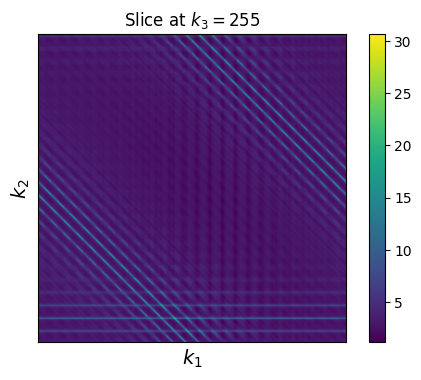

In [146]:
vertex3 = AutoEncoderVertexDataset.load_from_file('../../../frgs/tp0.020000_mu0.080000.h5')
axis, slice_at = 3, 255
vertvis.plot_section(vertex3, axis, slice_at, figsize=(6,4), title=f'Slice at $k_{axis}={slice_at}$')

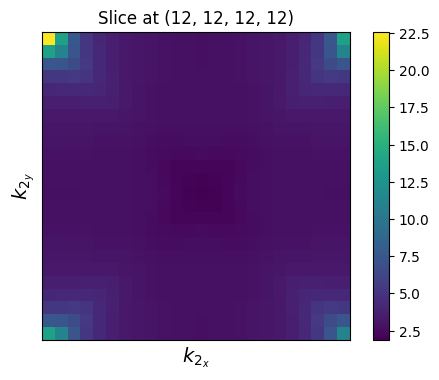

In [147]:
vertex6 = AutoEncoderVertex24x6Dataset.load_from_file('../../../frgs_6d/tp0.020000_mu0.080000.h5')
i = 12
axis, slice_at = 3, (i, i, i, i)
vertvis.plot_section(vertex6, axis, slice_at, figsize=(6,4), title=f'Slice at {(i, i, i, i)}')

## SVD

* compute SVD of 2D vertex slice
* 

In [ ]:
import numpy as np

v1 = AutoEncoderVertex24x6Dataset.load_from_file('../../../frgs_6d/tp0.020000_mu0.080000.h5')
v1_k1 = v1[:, :, 0, 0, 0, 0]
v1k1_svd = np.linalg.svd(v1_k1)

v2 = AutoEncoderVertex24x6Dataset.load_from_file('../../../frgs_6d/tp0.000000_mu0.000000.h5')
v2_k1 = v2[:, :, 0, 0, 0, 0]
v2k1_svd = np.linalg.svd(v2_k1)

((24, 24, 24, 24, 24, 24), (24, 24))

In [31]:
# correlation between eigenvectors of 2 matrices ordered by decreasing singular value
[np.correlate(ev1, ev2)[0] for ev1, ev2 in zip(v1k1_svd.Vh, v2k1_svd.Vh)]

[0.9999075858957209,
 0.9998693077547405,
 0.9999545211174288,
 0.9998833499326794,
 0.9997534159482703,
 0.9996404077938351,
 0.9990288741407005,
 0.9990786558628267,
 0.9993578411895877,
 0.9994547995930454,
 0.999721308158611,
 0.9970687178489733,
 0.9972945220151391,
 0.9998532999564047,
 0.9997460911950831,
 0.994434202145962,
 -0.09448512573161587,
 -0.09113746330528984,
 0.9800814654480636,
 0.9247336218289884,
 0.9528808022147215,
 -0.9419276762666988,
 0.0732536376996213,
 -0.12562347135480023]

# Sparse matrix representation

In [ ]:
from phys_ml.load_data.vertex import convert_6d_to_sparse_vertex

convert_6d_to_sparse_vertex('../../../frgs_6d', 0.8)

100%|██████████| 3/3 [01:28<00:00, 29.65s/it]


In [2]:
test_file = 'tp0.020000_mu0.080000.h5'
test_file3d = '../../../frgs/' + test_file
test_file6d = '../../../frgs_6d/' + test_file

save_path6d = 'save_AUTO_ENCODER_VERTEX_24X6_BS20_2025-01-11/version_2'
save_path3d = 'save_AUTO_ENCODER_VERTEX_BS20_2024-12-06/version_0'

vertex3 = AutoEncoderVertexDataset.load_from_file(test_file3d)
vertex6 = AutoEncoderVertex24x6Dataset.load_from_file(test_file6d)

In [ ]:
sparsify_rate = 0.8
p = AutoEncoderVertex24x6SparseDataset.compute_p()

vert = vertex3
values = vert.flatten()
cutoff = np.sort(values)[p > sparsify_rate].min()
sparse_vertex = vert.copy()
sparse_vertex[sparse_vertex < cutoff] = np.nan
sparse_vertex.shape

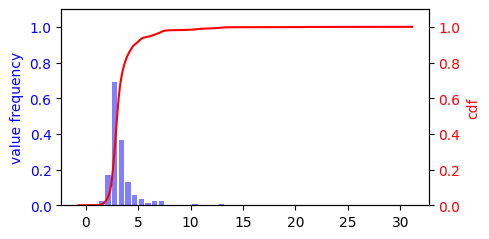

In [ ]:
import matplotlib.pyplot as plt
import numpy as np


val_sorted = np.sort(values)

f, ax1 = plt.subplots(figsize=(5,2.5))

color = 'b'
ax1.hist(values, bins=50, rwidth=0.8, density=True, color=color, alpha=0.5)
ax1.set_ylabel('value frequency', color=color)
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_ylim(0, 1.1)

ax2 = ax1.twinx()
color = 'r'
ax2.plot(val_sorted, p, color=color)
ax2.set_ylabel('cdf', color=color)
ax2.tick_params(axis='y', labelcolor=color)
ax2.set_ylim(ax1.get_ylim())

f.tight_layout()
plt.show()

del val_sorted, values

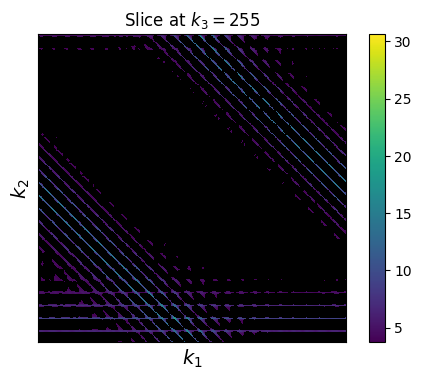

In [ ]:
axis, slice_at = 3, 255
print(f'compression rate: {sparsify_rate * 100:.1f}%')
vertvis.plot_section(sparse_vertex, axis, slice_at, figsize=(6,4), title=f'Slice at $k_{axis}={slice_at}$')

# U-Net